# Multi-arm Bandits

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2.2 Action-Value Methods

In [2]:
class NArmedBandit:
    def __init__(self, n=10, epsilon=0):
        self.n = n
        self.epsilon = epsilon
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)
        self.actions = []
        self.rewards = []

    def take_action(self):
        if self.epsilon > random.uniform(0, 1):
            # Explore
            selected_action = np.random.choice(range(self.n))
        else:
            # Exploit
            estimated_action_values = [self.estimated_value(action) for action in range(self.n)]
            max_value = np.max(estimated_action_values)
            ties = np.where(estimated_action_values == max_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax

        reward = self.reward(selected_action)

        self.actions.append(selected_action)
        self.rewards.append(reward)

        return selected_action, reward

    def optimal_action(self):
        return np.argmax(self.action_values)

    def estimated_value(self, action):
        if self.N(action) == 0:
            return 0
        else:
            previous_occurences = np.array(self.actions) == action
            sum_previous_rewards = np.array(self.rewards)[previous_occurences].sum()
            return sum_previous_rewards / self.N(action)

    def N(self, action):
        return self.actions.count(action)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)


In [6]:
bandits = [NArmedBandit(epsilon=0) for _ in range(100)]

In [7]:
reward_matrix = np.zeros((100, 1000))
optimal_action_matrix = np.zeros((100, 1000))

for bandit_index, bandit in tqdm(enumerate(bandits)):
    for step in range(1000):
        action, reward = bandit.take_action()
        reward_matrix[bandit_index, step] = reward
        optimal_action_matrix[bandit_index, step] = (1 if action == bandit.optimal_action() else 0)

100it [01:22,  1.22it/s]


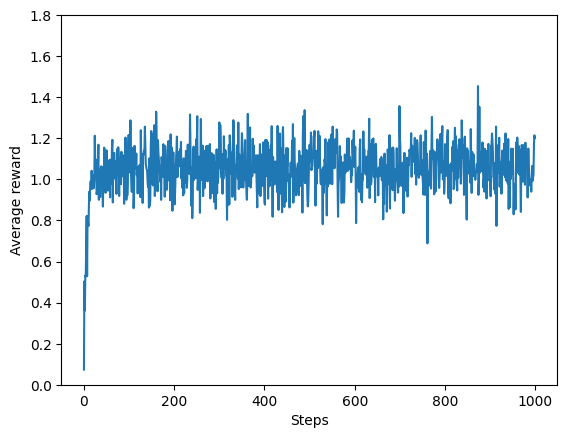

In [8]:
reward_averages= np.mean(reward_matrix, axis=0)
plt.plot(reward_averages)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.ylim(0, 1.8)
plt.grid(False)
plt.show()

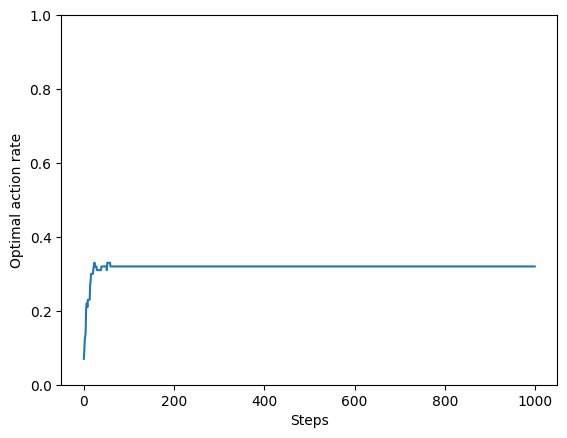

In [10]:
optimal_action_averages = np.mean(optimal_action_matrix, axis=0)
plt.plot(optimal_action_averages)
plt.xlabel("Steps")
plt.ylabel("Optimal action rate")
plt.ylim(0, 1)
plt.grid(False)
plt.show()

## 2.3 Incremental Implementation

In [46]:
class NArmedBanditIncremental:
    def __init__(self, n=10, epsilon=0):
        self.n = n
        self.epsilon = epsilon
        self.incremental_estimated_action_values = np.zeros(n)
        self.last_reward = 0
        self.action_counts = np.zeros(n)
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)

    def take_action(self):
        exploit = (random.uniform(0, 1) >= self.epsilon)

        if exploit:
            max_estimated_action_value = np.max(self.incremental_estimated_action_values)
            ties = np.where(self.incremental_estimated_action_values == max_estimated_action_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax
        else:
            selected_action = np.random.choice(range(self.n))

        self.action_counts[selected_action] += 1
        self.last_reward = self.reward(selected_action)

        self.update_incremental_estimated_action_values(selected_action)

        return selected_action, self.last_reward

    def optimal_action(self):
        return np.argmax(self.action_values)

    def update_incremental_estimated_action_values(self, action):
        k = self.action_counts[action]
        Q_k = self.incremental_estimated_action_values[action]
        R_k = self.last_reward
        self.incremental_estimated_action_values[action] = Q_k + (1 / k) * (R_k - Q_k)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)


In [12]:
bandit = NArmedBanditIncremental(epsilon=0.1)

In [13]:
bandit.incremental_estimated_action_values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
bandit.take_action()

(np.int64(1), np.float64(0.43396563304857105))

In [15]:
bandit.incremental_estimated_action_values

array([0.        , 0.43396563, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [16]:
bandit.take_action()

(np.int64(1), np.float64(0.9313616518962918))

In [17]:
bandit.incremental_estimated_action_values

array([0.        , 0.68266364, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [18]:
bandit.action_counts

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
class BanditAnalysis:
    def __init__(self, bandits, steps=1000):
        self.bandits = bandits
        self.reward_matrix = np.zeros((len(bandits), steps))
        self.optimal_action_matrix = np.zeros((len(bandits), steps))

    def fill(self):
        for bandit_index, bandit in tqdm(enumerate(self.bandits)):
            for step in range(1000):
                action, reward = bandit.take_action()
                self.reward_matrix[bandit_index, step] = reward
                self.optimal_action_matrix[bandit_index, step] = (1 if action == bandit.optimal_action() else 0)

    def plot_reward_averages(self, color, show=False):
        reward_averages= np.mean(self.reward_matrix, axis=0)
        plt.plot(reward_averages, color=color)
        plt.xlabel("Steps")
        plt.ylabel("Average reward")
        plt.ylim(0, 1.8)
        plt.grid(False)
        if show: plt.show()

    def plot_optimal_action_averages(self, color, show=False):
        optimal_action_averages = np.mean(self.optimal_action_matrix, axis=0)
        plt.plot(optimal_action_averages, color=color)
        plt.xlabel("Steps")
        plt.ylabel("Optimal action rate")
        plt.ylim(0, 1)
        plt.grid(False)
        if show: plt.show()
        

In [20]:
bandits_0 = [NArmedBanditIncremental(epsilon=0) for _ in range(2000)]
bandits_001 = [NArmedBanditIncremental(epsilon=0.01) for _ in range(2000)]
bandits_01 = [NArmedBanditIncremental(epsilon=0.1) for _ in range(2000)]

In [21]:
bandit_analysis_0 = BanditAnalysis(bandits_0)
bandit_analysis_001 = BanditAnalysis(bandits_001)
bandit_analysis_01 = BanditAnalysis(bandits_01)

In [22]:
bandit_analysis_0.fill()
bandit_analysis_001.fill()
bandit_analysis_01.fill()

2000it [01:58, 16.89it/s]
2000it [01:58, 16.89it/s]
2000it [01:56, 17.10it/s]


In [23]:
bandit = bandit_analysis_01.bandits[0]

In [24]:
bandit.action_counts

array([ 11.,  24.,  11., 299.,  13.,  13.,  15.,  12.,   9., 593.])

In [25]:
bandit.incremental_estimated_action_values

array([-1.5093664 ,  0.3222981 , -1.23077725,  1.02701256, -1.88302655,
       -0.32786239,  0.84038656, -1.39884117,  0.05051159,  0.90965075])

In [26]:
bandit.action_values

array([-1.4512864 ,  0.24745023, -1.04435565,  1.00233481, -1.83129567,
       -0.34545333,  0.89061659, -1.40964808,  0.08295465,  0.89714722])

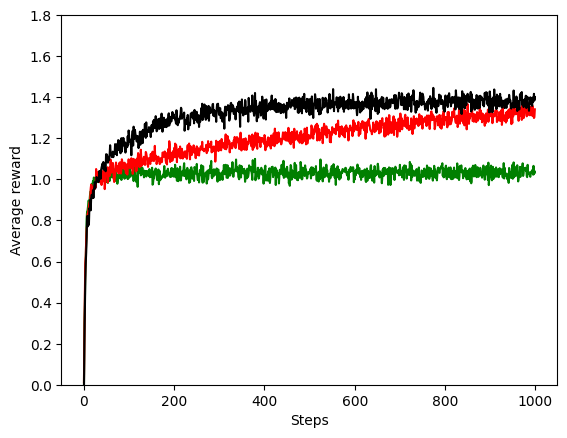

In [27]:
bandit_analysis_0.plot_reward_averages(color="green")
bandit_analysis_001.plot_reward_averages(color="red")
bandit_analysis_01.plot_reward_averages(color="black")


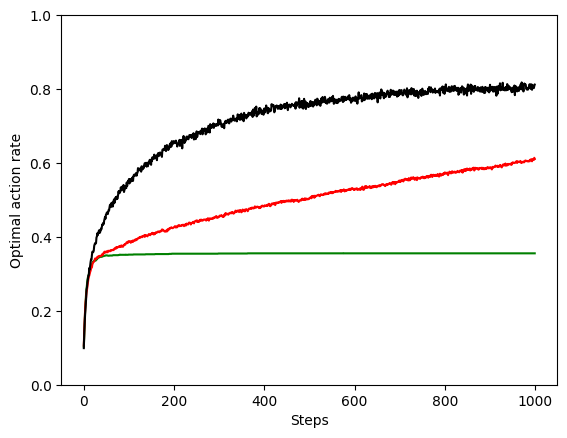

In [28]:
bandit_analysis_0.plot_optimal_action_averages(color="green")
bandit_analysis_001.plot_optimal_action_averages(color="red")
bandit_analysis_01.plot_optimal_action_averages(color="black")

## 2.5 Optimistic Initial Values

There is a bias for Q_1 estimates. If sample average, step (1/k), this estimate is only present if an action haven't been selected yet. In the above example, we initially had Q_1 = 0 for all actions.

If the step parameter alpha is constant. The bias will always be present but decreasing expontentially decreasing with the count of steps.

In [21]:
class NArmedBanditIncrementalWithInitialEstimateParamContantAlpha:
    def __init__(self, n=10, epsilon=0, initial_estimate_value=0, alpha=0.1):
        self.n = n
        self.epsilon = epsilon
        self.incremental_estimated_action_values = initial_estimate_value*np.ones(n)
        self.last_reward = 0
        self.action_counts = np.zeros(n)
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)
        self.alpha = alpha

    def take_action(self):
        exploit = (random.uniform(0, 1) >= self.epsilon)

        if exploit:
            max_estimated_action_value = np.max(self.incremental_estimated_action_values)
            ties = np.where(self.incremental_estimated_action_values == max_estimated_action_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax
        else:
            selected_action = np.random.choice(range(self.n))

        self.action_counts[selected_action] += 1
        self.last_reward = self.reward(selected_action)

        self.update_incremental_estimated_action_values(selected_action)

        return selected_action, self.last_reward

    def optimal_action(self):
        return np.argmax(self.action_values)

    def update_incremental_estimated_action_values(self, action):
        Q_k = self.incremental_estimated_action_values[action]
        R_k = self.last_reward
        self.incremental_estimated_action_values[action] = Q_k + (self.alpha) * (R_k - Q_k)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)

In [22]:
bandits_0_initial_5 = [NArmedBanditIncrementalWithInitialEstimateParamContantAlpha(epsilon=0, initial_estimate_value=5) for _ in range(2000)]
bandits_01_initial_0 = [NArmedBanditIncrementalWithInitialEstimateParamContantAlpha(epsilon=0.1, initial_estimate_value=0) for _ in range(2000)]

In [23]:
analysis_1 = BanditAnalysis(bandits_0_initial_5)
analysis_2 = BanditAnalysis(bandits_01_initial_0)

analysis_1.fill()
analysis_2.fill()

2000it [02:10, 15.30it/s]
2000it [01:58, 16.91it/s]


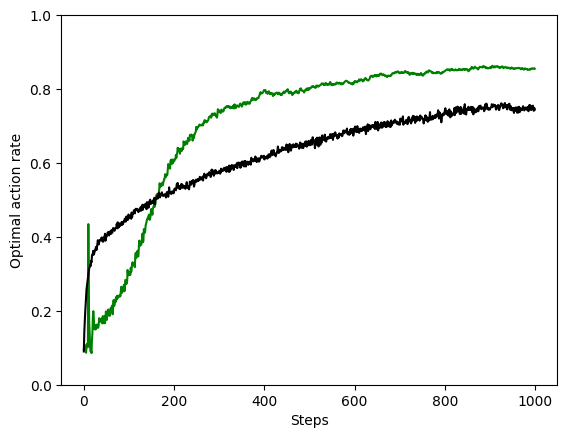

In [24]:
analysis_1.plot_optimal_action_averages(color="green")
analysis_2.plot_optimal_action_averages(color="black")

In the greedy case, we're showing that _optimistic initial values_ is an effective trick to use for stationary problems to encourage exploration and recieve better results. This method will not work for nonstationary problems because the they change over time and the need to exploration can be renewed when ever. This method is only focusing on the initial step.

_"Indeed, any method that focuses on the initial state in any special
way is unlikely to help with the general nonstationary case. The beginning
of time occurs only once, and thus we should not focus on it too much. This
criticism applies as well to the sample-average methods, which also treat the
beginning of time as a special event, averaging all subsequent rewards with
equal weights."_

## 2.6 Upper-Confidence-Bound Action Selection

_"It would be better to select among
the non-greedy actions according to their potential for actually being optimal,
taking into account both how close their estimates are to being maximal and
the uncertainties in those estimates. "_

In [61]:
class NArmedBanditIncrementalUCB:
    def __init__(self, c, n=10, epsilon=0):
        self.n = n
        self.epsilon = epsilon
        self.incremental_estimated_action_values = np.zeros(n)
        self.last_reward = 0
        self.action_counts = np.zeros(n)
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)
        self.c = c
        self.t = 1

    def take_action(self):
        exploit = (random.uniform(0, 1) >= self.epsilon)

        if exploit:
            objective = self.incremental_estimated_action_values + np.array(list(map(self.UCB, range(self.n))))
            max_estimated_action_value = np.max(objective)
            ties = np.where(objective == max_estimated_action_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax
        else:
            selected_action = np.random.choice(range(self.n))

        self.action_counts[selected_action] += 1
        self.last_reward = self.reward(selected_action)
        self.t += 1

        self.update_incremental_estimated_action_values(selected_action)

        return selected_action, self.last_reward

    def UCB(self, action):
        if self.action_counts[action] == 0:
            return np.inf
        else:
            return self.c*np.sqrt(np.log(self.t)/self.action_counts[action])

    def optimal_action(self):
        return np.argmax(self.action_values)

    def update_incremental_estimated_action_values(self, action):
        k = self.action_counts[action]
        Q_k = self.incremental_estimated_action_values[action]
        R_k = self.last_reward
        self.incremental_estimated_action_values[action] = Q_k + (1 / k) * (R_k - Q_k)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)


In [62]:
bandits_ucb = [NArmedBanditIncrementalUCB(c=2) for _ in range(2000)]
bandits_01 = [NArmedBanditIncremental(epsilon=0.1) for _ in range(2000)]

In [63]:
analysis_1 = BanditAnalysis(bandits_ucb)
analysis_2 = BanditAnalysis(bandits_01)

analysis_1.fill()
analysis_2.fill()

2000it [02:41, 12.40it/s]
2000it [01:12, 27.57it/s]


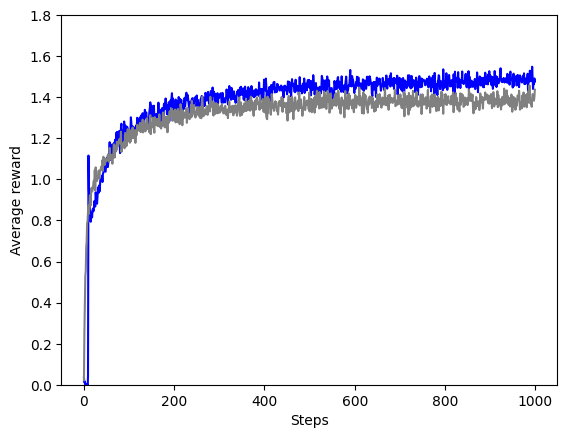

In [64]:
analysis_1.plot_reward_averages(color="blue")
analysis_2.plot_reward_averages(color="grey")